# Prize-Collecting Steiner Tree (PCSTP)

## Libs Importing

In [1]:
import sys
import os
import time
import networkx as nx
from typing import Tuple, Set

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
from pcstp.instances.generator import generate_random_steiner
from pcstp.utils.draw import draw_steiner_graph

## Experiments

In [3]:
G, (nodes, edges, position_matrix, edges_cost, terminals, prizes) = generate_random_steiner(
    num_nodes=25,
    num_edges=20,
    max_node_degree=10,
    min_prize=0,
    max_prize=100,
    num_terminals=5,
    min_edge_cost=0,
    max_edge_cost=10,
    cost_as_length=False,
    max_iter=100,
    seed=11
)

terminals:  (5,)
prizes:  (5,)


In [4]:
from pcstp.steinertree import SteinerTreeProblem
from pcstp.instances.reader import SteinlibReader, DatReader
from pcstp.solver.base import computes_steiner_cost

The instance can be imported from a file or generated through the instance generator presented above.

In [5]:
filename = '../data/instances/benchmark/PCSPG-JMP/K100.1.stp'

if filename.endswith('.stp'):
    stp_reader = SteinlibReader()
else:
    stp_reader = DatReader()

stp = stp_reader.parser(filename=filename)


In [6]:
# stp = SteinerTreeProblem(graph=G, terminals=terminals)

In [7]:
from pcstp.solver.base import computes_steiner_cost

In [8]:
from pcstp.utils.graph import preprocessing

In [9]:
G, terminals = preprocessing(stp.graph, stp.terminals)

In [10]:
stp_preprocessed = SteinerTreeProblem(graph=G, terminals=terminals)

In [11]:
# stp_preprocessed.graph.edges[(128, 127)]

## Solution obtained with NetworkX Steiner Tree Approximation Algorithm

In [12]:
start_time = time.time()

nx_steiner_tree = nx.algorithms.approximation.steinertree.steiner_tree(
    stp_preprocessed.graph,
    stp_preprocessed.terminals,
    weight='cost'
)

networkx_duration = time.time() - start_time
networkx_cost = computes_steiner_cost(stp_preprocessed.graph, nx_steiner_tree, stp_preprocessed.terminals)


In [13]:
print(f'Cost: {networkx_cost}')
print(f'Duration: {networkx_duration*1000} ms')

Cost: 259638.0
Duration: 36.0255241394043 ms


In [14]:
# draw_steiner_graph(
#     stp.graph,
#     steiner_graph=nx_steiner_tree,
#     plot_title=f'NetworkX Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
#     node_label='name'
# )


## Solution obtained with Greedy Heuristic Algorithm

In [15]:
from pcstp.solver.greedy_h1 import GreedyH1

In [16]:
# %%timeit -n 100

solver = GreedyH1(stp_preprocessed.graph, list(stp_preprocessed.terminals), log_level='info')
steiner_tree, greedy_cost = solver.solve()


In [17]:
print(f'Cost: {solver.steiner_cost}')
print(f'Duration: {solver._duration*1000} ms')

Cost: 323670.0
Duration: 40.82751274108887 ms


In [18]:
# %%timeit -n 100

preprocessed_graph_solver = GreedyH1(stp_preprocessed.graph, stp_preprocessed.terminals, log_level='info')
preprocessed_graph_steiner_tree, preprocessed_graph_greedy_cost = preprocessed_graph_solver.solve()

In [19]:
print(f'Cost: {preprocessed_graph_solver.steiner_cost}')
print(f'Duration: {preprocessed_graph_solver._duration*1000} ms')

Cost: 323670.0
Duration: 39.826154708862305 ms


In [20]:
# Cost: 323670.0
# Duration: 40.621042251586914 ms

# Cost: 417033.0
# Duration: 40.619850158691406 ms

In [21]:
print(f'Cost: {preprocessed_graph_greedy_cost}')

Cost: 323670.0


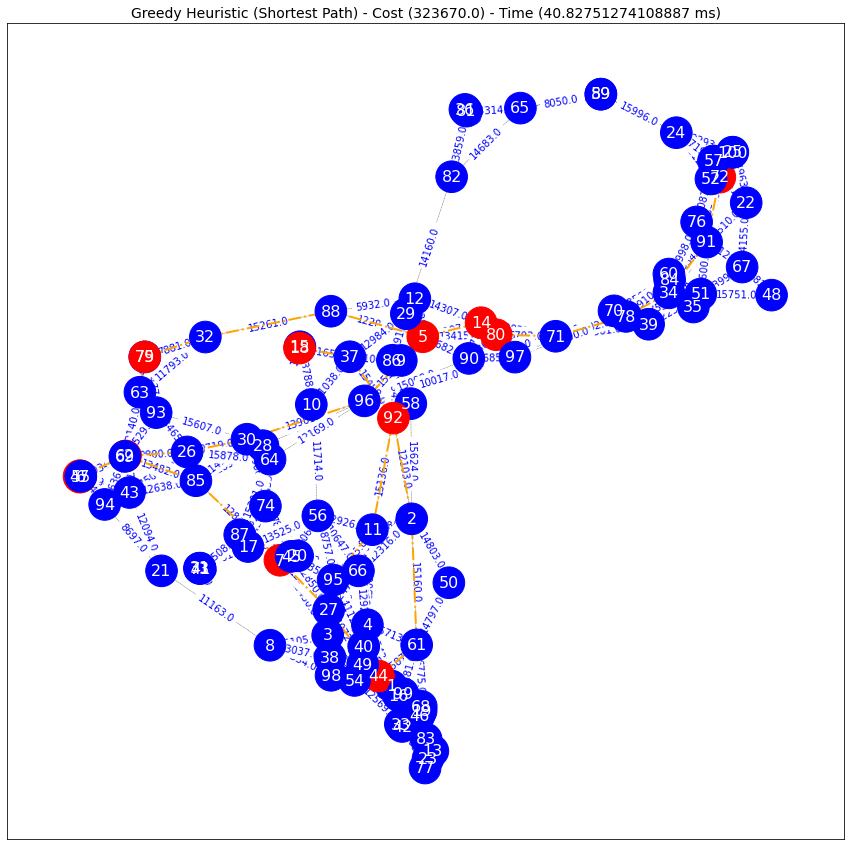

In [27]:
draw_steiner_graph(
    stp_preprocessed.graph,
    steiner_graph=steiner_tree,
    plot_title=f'Greedy Heuristic (Shortest Path) - Cost ({greedy_cost}) - Time ({solver._duration * 1000} ms)',
    node_label='name'
)

In [ ]:
# draw_steiner_graph(
#     stp.graph,
#     steiner_graph=preprocessed_graph_steiner_tree,
#     plot_title=f'Greedy Heuristic (Shortest Path) - Cost ({preprocessed_graph_greedy_cost}) - Time ({preprocessed_graph_solver._duration * 1000} ms)',
#     node_label='name'
# )
